## Overview

This notebook helps to detects lungs from Chest X-ray images. Lung Segmentation is a Computer vision process to detect lung cancer.

Medical Image Segmentation is the process of automatic detection of boundaries within images. In this exercise, we train a convolutional neural network with U-Net architecture, which training strategy relies on the strong use of data augmentation to improve the efficiency of available annotated samples.

The training is done with two chest x-rays datasets: One is actual image and the other one is the mask image of same x-ray. 

## Challenge
In order to find disease in these images well, it is important to first find the lungs well. This dataset is a collection of 2D and 3D images with manually segmented lungs.
For lung cancer detection it is important to find correct shape of lungs, which could help doctors to diagnose it better 

Import required Python libraries



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Model, load_model, save_model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam, RMSprop
from keras.backend.tensorflow_backend import set_session

sns.set(style='white', context='notebook', palette='deep')
import os
import numpy as np       # linear algebra
import pandas as pd      # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob    # finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
from skimage.util import montage 
from skimage.io   import imread
%matplotlib inline

## Data preparation

In [0]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-data-sets/1172/2106/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1587569715&Signature=Wuuns8ZMb1RvOntZueSyACDEuiLzOr6kQ0vt4jvA9TAFbYkWvsU1tAj41QuFVUqQHCq9rXoiJg%2Buo%2BUXiCqYouDilzNaAIYJepRl6b6iF6Y9adkWPHpgOZtGSv2exJ3SKHC6sIkbvWH8DBjsQ%2BJ21oEOjPMVzFHilCy1eHXioqcDqdC6uDE5NIcAIi7lstyABdgn3r6t2Izp431jDxsnObaW87Y0IpGK%2Bvw730GVajTi3fi8F7OqVxfj%2BTRXAFHCkpQF6T6bQzc%2BoONlUxCXA7vsI7TFLYqagADY5AJyXvTbbosPrSUs8m%2FLso62D49ah%2BA%2Br%2BbW64YSxRprdOHG3Q%3D%3D&response-content-disposition=attachment%3B+filename%3Dfinding-lungs-in-ct-data.zip" -c -O 'finding-lungs-in-ct-data.zip'

--2020-04-20 10:00:51--  https://storage.googleapis.com/kaggle-data-sets/1172/2106/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1587569715&Signature=Wuuns8ZMb1RvOntZueSyACDEuiLzOr6kQ0vt4jvA9TAFbYkWvsU1tAj41QuFVUqQHCq9rXoiJg%2Buo%2BUXiCqYouDilzNaAIYJepRl6b6iF6Y9adkWPHpgOZtGSv2exJ3SKHC6sIkbvWH8DBjsQ%2BJ21oEOjPMVzFHilCy1eHXioqcDqdC6uDE5NIcAIi7lstyABdgn3r6t2Izp431jDxsnObaW87Y0IpGK%2Bvw730GVajTi3fi8F7OqVxfj%2BTRXAFHCkpQF6T6bQzc%2BoONlUxCXA7vsI7TFLYqagADY5AJyXvTbbosPrSUs8m%2FLso62D49ah%2BA%2Br%2BbW64YSxRprdOHG3Q%3D%3D&response-content-disposition=attachment%3B+filename%3Dfinding-lungs-in-ct-data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 2607:f8b0:400c:c13::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1108422436 (1.0G) [application/zip]
Saving to: ‘finding-lungs-in-ct-data.zip’

finding-lungs-in-ct 100

In [0]:
!unzip finding-lungs-in-ct-data.zip

## Locate all the x-ray images and mask files from the folder

In [0]:
IMG_PATH = os.path.join('/content/')
DS_FACT = 2
SEED=42

image_files = glob(os.path.join(IMG_PATH,'2d_images/','*.tif'))
mask_files  = glob(os.path.join(IMG_PATH,'2d_masks','*.tif'))

print('No. of images:', len(image_files))
print(image_files[0])
print(mask_files[0])

No. of images: 267
/content/2d_images/ID_0187_Z_0145.tif
/content/2d_masks/ID_0187_Z_0145.tif


## Load and check some of the images from the data

(1, 256, 256)


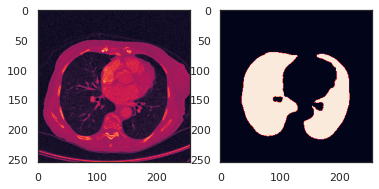

In [0]:
test_image = np.expand_dims(imread(image_files[5])[::2, ::2],0)
test_mask  = np.expand_dims(imread(mask_files[5])[::2, ::2],0)/255.0
fig, (ax1 ,ax2) = plt.subplots(1, 2)
ax1.imshow(test_image[0])
ax2.imshow(test_mask[0])
print(test_image.shape)

## Load all the images and masks. Normalize X-ray images and mask for faster training. Check min and max value of image pixels 


In [0]:
images  = np.stack((np.expand_dims(imread(i)[::DS_FACT, ::DS_FACT], -1) for i in image_files),0)
masks   = np.stack((np.expand_dims(imread(i)[::DS_FACT, ::DS_FACT]/255., -1) for i in mask_files),0)
                  
X_train, X_test, y_train,  y_test = train_test_split(images, masks, test_size=0.1)

print('X_train - len/shape:', len(X_train), X_train.shape)
print('Y_train is {}, min is {}, max is {}, mean is {}'.format(y_train.shape, y_train.min(), y_train.max(), y_train.mean()))
print('X_test  - len/shape:', len(X_test), y_test.shape)
print(images.shape[:])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


X_train - len/shape: 240 (240, 256, 256, 1)
Y_train is (240, 256, 256, 1), min is 0.0, max is 1.0, mean is 0.23656552632649738
X_test  - len/shape: 27 (27, 256, 256, 1)
(267, 256, 256, 1)


## U-NET Model

U-Net takes its name from the architecture, which when visualized, appears similar to the letter U, as shown in the figure below. Input images are obtained as a segmented output map. The most special aspect of the architecture in the second half. The network does not have a fully-connected layer. Only the convolution layers are used. Each standard convolution process is activated by a ReLU activation function.

[link text](https://miro.medium.com/max/1400/0*HSX89sT__0ZsWJRE.png)

![alt text](https://miro.medium.com/max/1400/0*HSX89sT__0ZsWJRE.png)

In [0]:
def unet_model(inputs, n=32):
    bn    = BatchNormalization()(inputs)  
    conv1 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(bn)
    conv1 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.1)(pool1)

    conv2 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.1)(pool2)

    conv3 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.1)(pool3)

    conv4 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)    
    pool4 = Dropout(0.1)(pool4)

    convm = Conv2D(n*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    convm = Conv2D(n*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convm)

    up6   = Conv2DTranspose(n*8, (2, 2), strides=(2, 2), padding='same')(convm)
    conv6 = concatenate([up6, conv4])
    conv6 = Dropout(0.1)(conv6)                   
    conv6 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up7   = Conv2DTranspose(n*4, (2, 2), strides=(2, 2), padding='same')(conv6)
    conv7 = concatenate([up7, conv3])
    conv7 = Dropout(0.1)(conv7)
    conv7 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)

    up8   = Conv2DTranspose(n*2, (2, 2), strides=(2, 2), padding='same')(conv7)
    conv8 = concatenate([up8, conv2])
    conv8 = Dropout(0.1)(conv8)  
    conv8 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)

    up9   = Conv2DTranspose(n, (2, 2), strides=(2, 2), padding='same')(conv8)
    conv9 = concatenate([up9, conv1])
    conv9 = Dropout(0.1)(conv9) 
    conv9 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)

    output = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[output])

## Define the model

In [0]:
input_img = Input(X_train.shape[1:], name='img')
n_filters   = 32

model = unet_model(input_img, n_filters)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 1)  4           img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
____________________________________________________________________________________________

## Include callbacks and save model for future use

## Callbacks
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential or Model classes. The relevant methods of the callbacks will then be called at each stage of the training.

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lung.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
Model_Run = model.fit(X_train, y_train, batch_size=10, epochs=15, callbacks=callbacks, \
                    validation_data=(X_test, y_test))

Train on 240 samples, validate on 27 samples
Epoch 1/10
240/240 [==============================] - 450s 2s/step - loss: 0.1661 - accuracy: 0.9496 - val_loss: 0.3440 - val_accuracy: 0.8549

Epoch 00001: val_loss did not improve from 0.28153
Epoch 2/10
240/240 [==============================] - 450s 2s/step - loss: 0.0966 - accuracy: 0.9703 - val_loss: 0.0337 - val_accuracy: 0.9914

Epoch 00002: val_loss improved from 0.28153 to 0.03373, saving model to model-lung.h5
Epoch 3/10
240/240 [==============================] - 449s 2s/step - loss: 0.0612 - accuracy: 0.9845 - val_loss: 0.0289 - val_accuracy: 0.9899

Epoch 00003: val_loss improved from 0.03373 to 0.02888, saving model to model-lung.h5
Epoch 4/10
240/240 [==============================] - 451s 2s/step - loss: 0.1127 - accuracy: 0.9805 - val_loss: 0.0694 - val_accuracy: 0.9740

Epoch 00004: val_loss did not improve from 0.02888
Epoch 5/10
240/240 [==============================] - 449s 2s/step - loss: 0.0566 - accuracy: 0.9850 - va

## Save model weights for future runs

In [0]:
model.load_weights('model-lung.h5')

## Model Evaluation

In [0]:
def plot_Evaluation(history, title):
    plt.figure(figsize=(10,3))
    # Plot training & validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

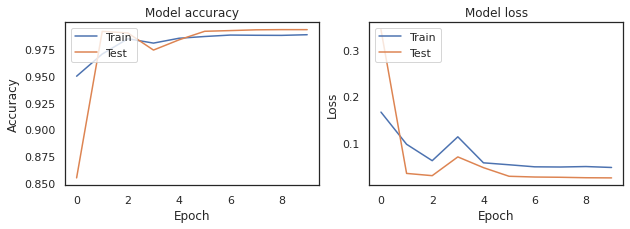

In [0]:
plot_Evaluation(Model_Run, 'UNet Loss/Accuracy')

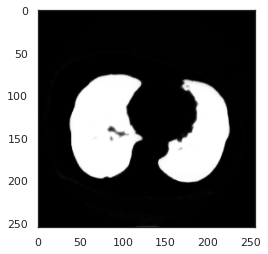

In [0]:
plt.imshow(
    model.predict(X_train[0].reshape(1,256, 256, 1))[0,:,:,0], 
    cmap='gray')

## Show the predictions of all validation cases

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


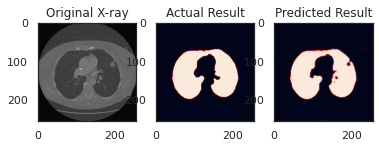

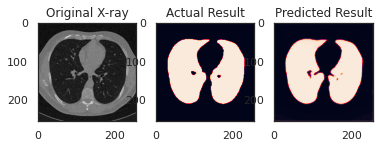

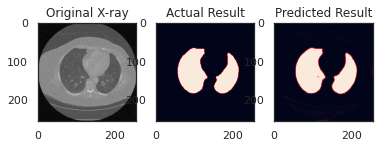

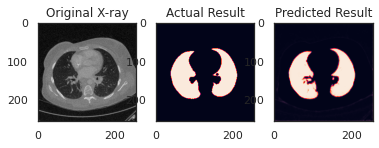

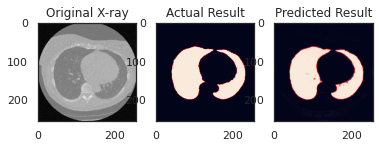

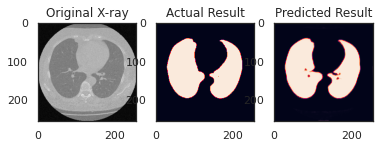

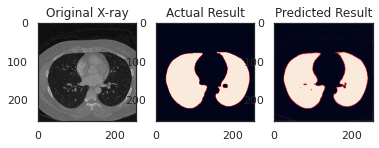

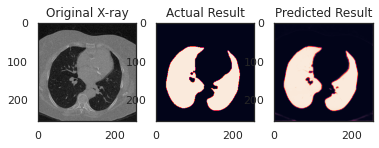

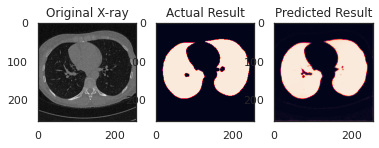

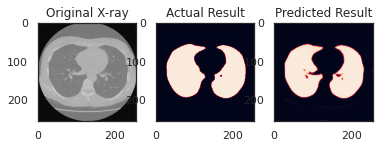

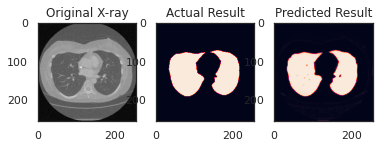

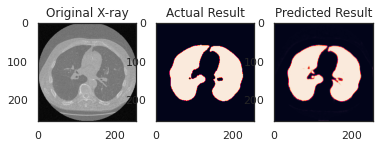

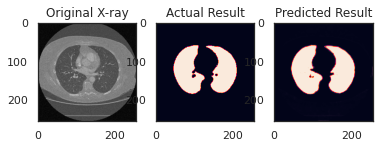

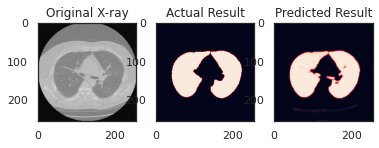

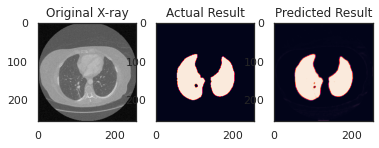

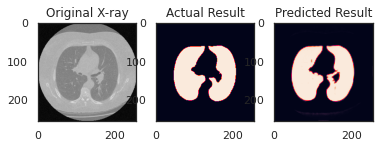

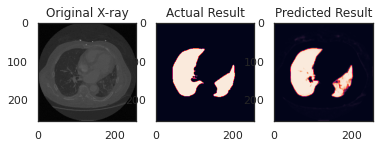

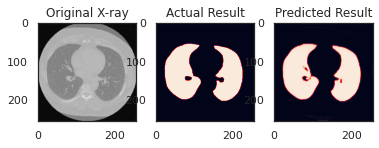

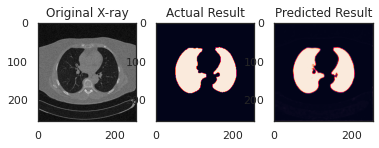

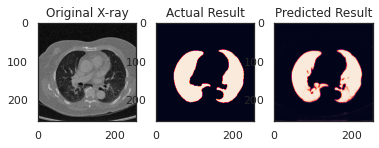

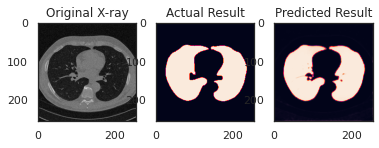

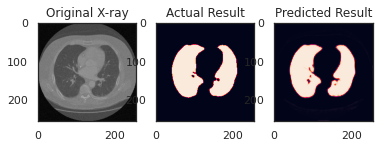

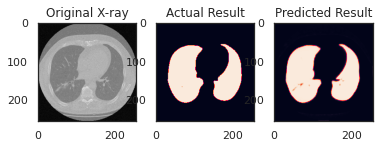

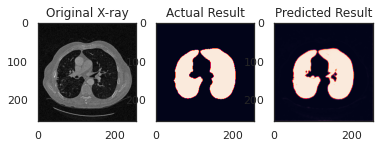

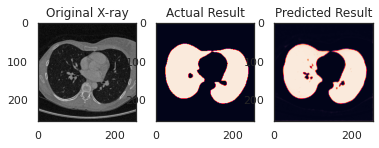

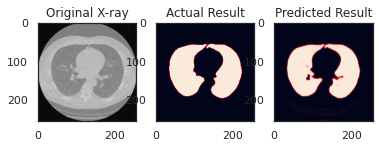

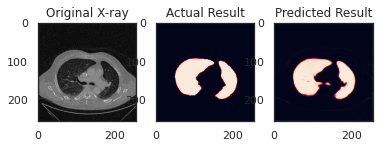

In [0]:
y_predict = model.predict(X_test)

for i in range(X_test.shape[0]): 
    fig, ax = plt.subplots(1,3,figsize=(6,6))
    ax[0].set_title('Original X-ray')
    ax[1].set_title('Actual Result')
    ax[2].set_title('Predicted Result')
    ax[0].imshow(X_test[i,:,:,0], cmap='gray')
    ax[1].imshow(y_test[i,:,:,0])
    ax[2].imshow(y_predict[i,:,:,0])